# Projet Optimisation Groupe 1 


## 1 Modélisation


### 1. Formuler la fonction objectif du problème. On pourra supposer l’existence de deux tarifs électriques (heures pleines et heures creuses)

Etant donné qu'il est précisé qu'on ait à considérer deux tarifs, la fonction d'optimisation doit être le cout en euros du nombre de kWh utilisé. Le but étant de minimiser ce coût en achetant de l'éléctricité pendant les heures creuses. On a une contrainte triple, à savoir :
- le temps de recharge est imposé par l'utilisateur (c'est lui qui fixe l'heure de départ)
- le niveau final de la batterie aussi (c'est lui qui décidé si il veut une charge à 80% ou 95%)
- la puissance maximale fournie par le réseau (on ne peut pas dépasser cette puissance, je ne suis pas sûr si il s'agit de la puissance totale que peut débiter le réseau à toutes les voitures en même temps, ou la puissance maximale qu'on puisse fournir à une voiture)


Il y a peut-être d'autres contraintes sur le fonctionnement du système de rechage, celui-ci est peut-être plus performant lorsque'il y a peu de voitures à recharger simultanément par exempe. Enfin on peut également considérer la puissance maximale de récéption d'un véhicule, qui peut d'ailleurs varier d'un véhicule à l'autre


### 2. Formuler un modèle dynamique reliant l’état de charge d’un véhicule et la puissance qui lui est fournie.


On connaît l'énergie à fournir aux véhicules et le temps qu'on a, en fonction de ce que l'utilisateur demande. Il suffit de diviser cette énergie par cette durée et on obtient la puissance moyenne à fournir sur toute la durée. 

On commence par fournir une puissance maximale pendant les heures à tarif réduits. Cette puissance n'est pas nécessairement la puissance maximale que peut recevoir la voiture Pi < Pmax, car il y aura surement d'autre véhicules branchées en même temps et dans ce cas la contrainte serait sur la puissance totale (aka la puissance que le système peut recevoir du réseau) : Somme des Pi = Préseau. 

Puis si il reste de l'énergie à fournir, on utilise une puissance minimale sur les heures à tarifs complets.  Somme des Pi < Préseau 
Ou mieux on décharge certaines voitures pour en charger d'autres à un niveau de charge plus bas. En essayant ainsi de tendre vers une charge moyenne pour toutes les voitures. 


En résumé : 
-Si l'on est en heure tarifs pleins : on tend vers une charge moyenne sans solicité le courant du réseau en équilibrant les charges entre les voitures.
-Si l'on est en heure tarifs creuses :  on fait monter la valeur de la charge moyenne en solicitant le courant réseau. 

Dans les deux cas de figure il faut délivrer les voitures chargés à l'heure indiqué donc on prévoit une durée limite avant le départ d'une voiture pour employer nécessairement le réseau où les autres voitures pour charger celle qui va partir. 

Ce qui pourrait être encore plus efficace serait de définir une moyenne de charge pondérée qui prend en compte le temps restant pour charger une voiture i , et qui adapate le chargement de la voiture i à ce moment : Par exemple si une voiture va passer beaucoup de temps dans le réseau, son niveau de charge a un poids plus important dans la moyenne. Tandis que si son départ est imminent son poids dans la moyenne est plus faible. 

Sinon si la question était en fait une question de physique bah *Uréseau* x *Qmax* x *dq/dt* = *Pfournie*


### 3.  Proposer une méthodologie d’identiﬁcation de ce modèle basée sur les données fournies sur Oasis et la mettre en oeuvre.

Nous ne sommes toujours pas certain d'avoir compris la question mais nous allons essayer d'exploiter les données au maximum, c'est à dire trouver Qmax la charge maximale d'une voiture qui doit donc vérifier la relation *Qmax x dq/dt = i* 
avec q la charge relative et i l'intensité en ampères, t le temps en seconde.

Nous commençons par extraire les données dans des listes respectives pour t, i et q. Puis nous construisons par une différenciation discrète simple les valeurs dq/dt et di/dt qui nous servirons par la suite. 

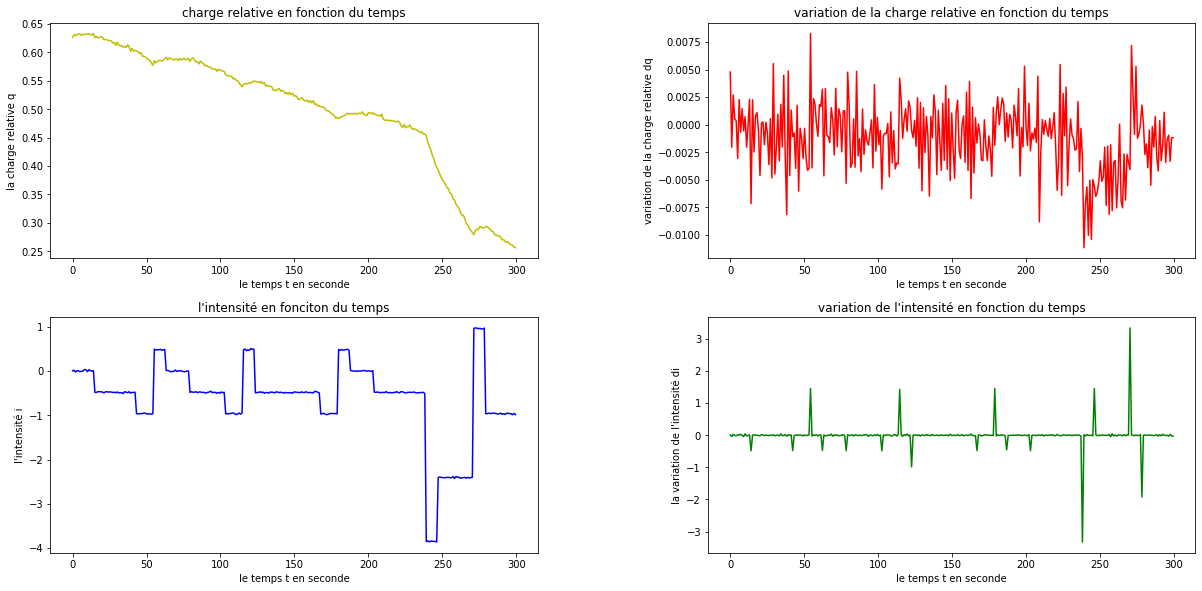

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

t=[]
i=[]
q=[]

data = open("donnees-projet-gr1.txt","r")
data = data.read()
data = data.replace('\t','\n')
data = str.split(data)

for k in range (len(data)):
    if k%3==0:
        t.append(data[k])
    elif k%3 == 1 :
        i.append(data[k])
    elif k%3 == 2:
        q.append(data[k])

n = len(q)

for k in range(n):
    t[k], q[k], i[k] = float(t[k]), float(q[k]), float(i[k])


dq = []
di = []

for k in range(n-1):
    dq.append((q[k+1]-q[k])/(t[k+1]-t[k]))
    di.append((i[k+1]-i[k])/(t[k+1]-t[k]))
    
dq.append(dq[-1]) #on double le dernier élément à la fin de la liste simplement pour qu'elles aient la même longueur que q et i
di.append(di[-1])


plt.figure()

plt.subplot(2,2,1)
plt.plot(t,q,'y')
plt.xlabel("le temps t en seconde")
plt.ylabel("la charge relative q")
plt.title("charge relative en fonction du temps")


plt.subplot(2,2,2)
plt.plot(t,dq,'r')
plt.xlabel("le temps t en seconde")
plt.ylabel("variation de la charge relative dq")
plt.title('variation de la charge relative en fonction du temps')


    
plt.subplot(2,2,3)
plt.plot(t,i,'b')
plt.xlabel("le temps t en seconde")
plt.ylabel("l'intensité i")
plt.title("l'intensité en fonciton du temps")

    
plt.subplot(2,2,4)
plt.plot(t,di,'g')
plt.xlabel("le temps t en seconde")
plt.ylabel("la variation de l'intensité di")
plt.title("variation de l'intensité en fonction du temps")

plt.subplots_adjust(top=1.92, bottom=0.08, left=0.10, right=2.75, hspace=0.25,
                    wspace=0.35)

plt.show()

Nous nous rendons compte en rédigeant que nous aurions aussi pu intégrer i pour essayer d'aproximer q plutôt que de dériver q pour retrouver i. Mais lors de notre étape de recherche ce qui nous a frappé a été que les graphes de dq et de i se superposé presque à un "bruit" près pour peu que l'on trouve un facteur multiplicateur de correction adéquat. Prenons içi 520 par exemple.

Text(0, 0.5, "en bleu dq/dt corrigé et en jaune l'intensité")

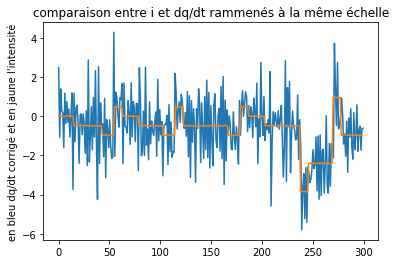

In [2]:
dq_corrigé=[]

for k in range(len(dq)):
    dq_corrigé.append(dq[k]*520)
    
plt.plot(t,dq_corrigé,i)
plt.title('comparaison entre i et dq/dt rammenés à la même échelle')
plt.ylabel("en bleu dq/dt corrigé et en jaune l'intensité")

Très clairement le bruit sur dq/dt semble énorme mais il suit en moyenne la courbe de l'intensité. 
Nous tentons donc d'éliminer ce bruit en faisant la moyenne par paliers d'intensité de dq/dt. Le critère retenue pour déterminer un palier sera une variation d'intensité supérieur à 0.1 en norme.

In [3]:
paliers = [-1]
for k in range(n): 
    if di[k] > 0.1 or di[k] < -0.1 :
        paliers.append(k)
paliers.append(298)

print(f'les paliers sont {paliers}')

les paliers sont [-1, 14, 42, 54, 62, 78, 102, 114, 122, 166, 178, 186, 202, 237, 245, 269, 277, 298]


On retrouve bien le même nombre de paliers que l'on peut en dénombrer à l'oeuil sur le graphe. On continue sur cette piste en procédant à la moyenne par paliers.

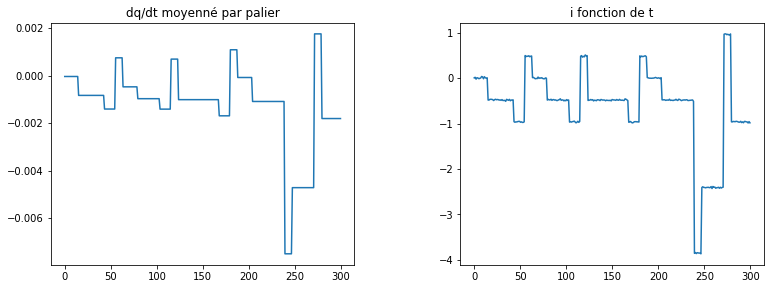

In [4]:
dqq=[]

for kk in range(1,len(paliers)) :  #Cette boucle permet de passer d'un palier à un autre. Dans chaque boucle on cherche la valeur
                                    #moyenne de dq qui sera la nouvelle valeur prise en tout point de ce palier par dq
    new_dq = 0
    compteur = 0
    for x in dq[paliers[kk-1]+1:paliers[kk]+1] : #la construction de dq par différenciation fait que le premier terme du palier 
                                                # est exclus et que le dernier est inclus
        new_dq += x
        compteur+=1
    new_dq = new_dq/compteur

    for k in range(paliers[kk-1]+1,paliers[kk]+1):
        dqq.append(new_dq)

plt.figure
plt.subplot(121)
plt.plot(t,dqq)
plt.title("dq/dt moyenné par palier")

plt.subplot(122)
plt.plot(t,i)
plt.title("i fonction de t")

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=1.75, hspace=0.25,
                    wspace=0.35)

plt.show()

Cette fois ci les deux graphes sont complètement similaire. Il ne reste plus qu'à trouver Qmax en procédent à une moyenne de i divisé par dq/dt. On prend soin d'éliminer les cas des paliers d'intensité trop faible qui fausse complètement la moyenne. 

La valeur que l'on retiendra finalement pour la charge maximal d'une voiture sera Qmax=531.5 Coulombs!


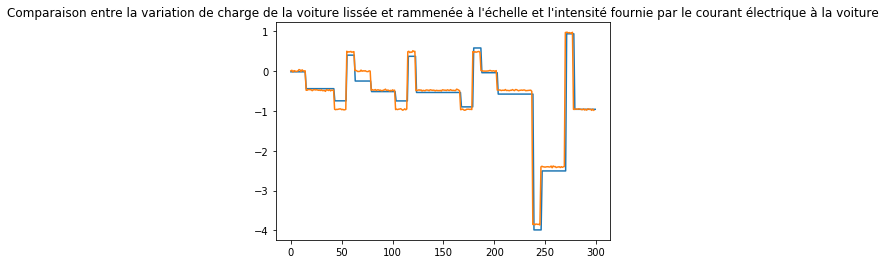

In [5]:
Qmax=0
compteur=0

for k in range(len(dq)):
    if i[k]>0.1 or i[k] < -0.1 : 
        Qmax+=(i[k]/dqq[k])
        compteur+=1
Qmax /= compteur

print(f"La valeur que l'on retiendra finalement pour la charge maximal d'une voiture sera Qmax={round(Qmax,1)} Coulombs!")

for k in range(len(dqq)):
    dqq[k]= dqq[k]*Qmax
    
plt.plot(t,dqq,i)
plt.title("Comparaison entre la variation de charge de la voiture lissée et rammenée à l'échelle et l'intensité fournie par le courant électrique à la voiture")
plt.show()

Si les deux graphes ne se superposent pas parfaitement c'est peut-être parceque nous sommes passés par une méthode par dérivation alors qu'il aurai fallu intégrer l'intensité pour retrouver le niveau de charge de la voiture. Cependant comme le chevauchement des deux graphes semblent avoir des défauts aléatoire (c'est à dire que l'un des graphes est parfois en dessous parfois au dessus de l'autre) nous nous permetons de juger le résultat Qmax = 535,5 Coulombs comme satisfaisant! 

### 4. Formaliser les contraintes restantes du problème et formuler le problème de minimisation correspondant. On précisera en particulier les variables de décision, les contraintes (au nombre de six) et la fonction objectif du problème.

On peut choisir comme variable du problème l'intensité délivrée à chaque voiture. En supposant que la tension U est la même pour dans chaque branche (tension du réseau et tension de chaque voiture tel un circuit parralèle), on a ainsi une relation simple entre l'intensité et l'énergie à savoir $ E = U*I*t $ 

On construit donc un vecteur $I$ telle que sa première coordonnée $I_{0}$ soit le courant fournie par le réseau. 

Pour tout $k$ entre $1$ et $n$,  $I_{k}$ correspond à l'intensité fournie à la voiture $k$ avec $n$ le nombre de voitures maximale.


Ainsi postulé on cherche à minimiser l'intégrale de $f(t) = P(t)*U*I_{0}(t)$ sur une durée d'opération donnée. Avec $P$ la fonction prix qui à une heure donnée associe le tarif.

On désigne par $t_{k}^{i}$ et $t_{k}^{f}$ l'heure d'arrivée et l'heure de départ du vehicule k renseignée par l'utilisateur ainsi que $q_{k}^{i}$ et $q_k^{f}$ le niveau de charge relatif initial et final souhaité par l'utilisateur.

On se retrouve avec comme contrainte : 
- pour tout $k$ , l'intégrale de $i_{k}(t)$ entre $t_{k}^{i}$ et $t_{k}^{f}$ doit valoir $(q_k^{f} - q_{k}^{i})*Qmax$ qui correspond à l'obligation de délivrer la voiture chargée à l'heure donnée.
- Pour tout k>0 $i_{k}(t)$ est nulle en dehors des valeurs de temps respectifs
- A tout instant et pour tout $k$, $-Imax < i_{k}(t) < Imax $ ainsi que $ 0 < I_{0} < I max$ correspond au courant maximale que peut délivrer le réseau et que peut recevoir une voiture, qu'on approxime à la même valeur par souci de simplicité.
- De plus par une simple loi des noeuds dans notre circuit on a nécessairement à tout instant : Somme sur $k$ de $0$ à $n$ des $I_{k}(t) < Imax$
- Pour tout k à tout instant t, $i_k(t)$ = $dq_{k}(t)/dt$, simple considération physique qui nous permettra peut-être d'éviter les calculs d'intgrales? 
- Enfin pour ne pas détruite les batteries on a pour tout k à tout instant t $0<q_{k}(t)<1$